# NEURO-105: Statistics and Probability using Python
## Lesson 3 - Monday 26/1/26

**Instructor:** Alexandros Pittis  
**Course:** MSc in Neurosciences, University of Crete

---

### Objectives
1. Loading real data from CSV files
2. Understanding p-values
3. Comparing two groups: t-test
4. Non-parametric alternative: Mann-Whitney U test

---

## Setup

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

print("Libraries loaded!")

Libraries loaded!


---
## Part 1: Loading Real Data

Today we'll work with **gene expression data** from a Parkinson's disease study.

The data contains:
- 20 brain tissue samples (globus pallidus)
- 10 healthy controls, 10 Parkinson's patients
- Expression levels of 15 genes related to neurodegeneration

**Data source:** Based on GEO dataset GSE20146

### Loading a CSV file

CSV = Comma Separated Values - a simple text format for tabular data.

In [ ]:
# Load data from a URL (hosted on GitHub)
url = "https://raw.githubusercontent.com/cgenomicslab/Courses/refs/heads/main/MScNeuro/2026/data/parkinsons_expression.csv"

data = pd.read_csv(url)

data

In [13]:
!ls -l ../

total 40
-rw-r--r--@ 1 alxndrs  staff  5589 Jan 22 11:12 README.md
-rw-r--r--@ 1 alxndrs  staff  7396 Jan 15 18:44 SETUP.md
drwxr-xr-x@ 3 alxndrs  staff    96 Jan 22 11:12 data
drwxr-xr-x@ 9 alxndrs  staff   288 Jan 26 13:15 notebooks
-rw-------@ 1 alxndrs  staff   127 Jan 14 16:33 requirements.txt


### Alternative: Load from a local file

If you have the file downloaded:
```python
data = pd.read_csv("/Users/alxndrs/Documents/courses/Courses/MScNeuro/2026/data/parkinsons_expression.csv")
```

Or with full path:
```python
data = pd.read_csv("/path/to/your/file.csv")
```

In [9]:
data = pd.read_csv("/Users/alxndrs/Documents/courses/Courses/MScNeuro/2026/data/parkinsons_expression.csv")
data

,sample_id,condition,SNCA,PARK2,PINK1,DJ1,LRRK2,GBA,ATP13A2,MAPT,BDNF,TH,SLC6A3,DRD2,COMT,GAD1,SYP
0,S01,Control,8.2,7.5,6.8,7.1,5.9,8.3,6.2,7.8,6.5,9.1,7.2,6.8,7.4,8.1,7.9
1,S02,Control,7.9,7.8,6.5,7.3,6.1,8.1,6.4,7.5,6.8,8.8,7.5,6.5,7.2,8.3,8.1
2,S03,Control,8.4,7.2,6.9,6.9,5.7,8.5,6.1,7.9,6.3,9.3,7.0,6.9,7.6,7.9,7.7
3,S04,Control,8.0,7.6,6.6,7.2,6.0,8.0,6.3,7.6,6.6,8.9,7.3,6.6,7.3,8.2,8.0
4,S05,Control,8.3,7.4,6.7,7.0,5.8,8.4,6.0,7.7,6.4,9.0,7.1,6.7,7.5,8.0,7.8
5,S06,Control,7.8,7.9,6.4,7.4,6.2,7.9,6.5,7.4,6.9,8.7,7.6,6.4,7.1,8.4,8.2
6,S07,Control,8.1,7.3,6.8,7.1,5.9,8.2,6.2,7.8,6.5,9.2,7.2,6.8,7.4,8.1,7.9
7,S08,Control,8.5,7.1,7.0,6.8,5.6,8.6,5.9,8.0,6.2,9.4,6.9,7.0,7.7,7.8,7.6
8,S09,Control,7.7,8.0,6.3,7.5,6.3,7.8,6.6,7.3,7.0,8.6,7.7,6.3,7.0,8.5,8.3
9,S10,Control,8.2,7.5,6.7,7.0,5.9,8.3,6.2,7.7,6.5,9.0,7.2,6.7,7.4,8.1,7.9


### Exploring the data

In [14]:
# Shape: (rows, columns)
data.shape

(20, 17)

In [15]:
# Column names
data.columns

Index(['sample_id', 'condition', 'SNCA', 'PARK2', 'PINK1', 'DJ1', 'LRRK2',
       'GBA', 'ATP13A2', 'MAPT', 'BDNF', 'TH', 'SLC6A3', 'DRD2', 'COMT',
       'GAD1', 'SYP'],
      dtype='object')

In [16]:
# Data types
data.dtypes

sample_id     object
condition     object
SNCA         float64
PARK2        float64
PINK1        float64
DJ1          float64
LRRK2        float64
GBA          float64
ATP13A2      float64
MAPT         float64
BDNF         float64
TH           float64
SLC6A3       float64
DRD2         float64
COMT         float64
GAD1         float64
SYP          float64
dtype: object

In [17]:
# How many samples per condition?
data['condition'].value_counts()

condition
Control    10
PD         10
Name: count, dtype: int64

In [18]:
# Summary statistics
data.describe()

,SNCA,PARK2,PINK1,DJ1,LRRK2,GBA,ATP13A2,MAPT,BDNF,TH,SLC6A3,DRD2,COMT,GAD1,SYP
count,20.000000,20.00000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,8.960000,6.84000,6.260000,6.690000,6.39500,7.630000,5.795000,8.110000,6.060000,8.075000,6.510000,6.260000,7.255000,7.745000,7.445000
std,0.910408,0.75212,0.471727,0.499368,0.51245,0.639161,0.503122,0.499368,0.572529,0.977039,0.813634,0.471727,0.237254,0.457079,0.550096
min,7.700000,5.80000,5.500000,5.900000,5.60000,6.700000,5.000000,7.300000,5.200000,6.800000,5.400000,5.500000,6.800000,7.000000,6.600000
25%,8.175000,6.17500,5.875000,6.275000,5.90000,7.075000,5.375000,7.700000,5.575000,7.175000,5.775000,5.875000,7.100000,7.375000,6.975000
50%,8.950000,6.80000,6.250000,6.700000,6.40000,7.600000,5.800000,8.100000,6.050000,8.050000,6.500000,6.250000,7.250000,7.750000,7.450000
75%,9.800000,7.50000,6.700000,7.100000,6.82500,8.225000,6.200000,8.525000,6.500000,9.000000,7.200000,6.700000,7.400000,8.100000,7.900000
max,10.300000,8.00000,7.000000,7.500000,7.20000,8.600000,6.600000,8.900000,7.000000,9.400000,7.700000,7.000000,7.700000,8.500000,8.300000


### Genes' info

| Gene | Function |
|------|----------|
| SNCA | Alpha-synuclein - aggregates in Parkinson's |
| PARK2 | Parkin - mutations cause PD |
| PINK1 | Sensor for mitochondrial damage |
| TH | Tyrosine hydroxylase - dopamine biosynthesis enzyme |
| SLC6A3 | Dopamine transporter |
| BDNF | Brain-derived neurotrophic factor |

---
## Part 2: What is a P-value?

Before we do any tests, let's see what we're calculating.

### The Question

We have two groups (Control vs PD). They have different mean expression levels.

**Is this real difference, or just random chance?**

In [23]:
data[data['condition'] == 'Control']

,sample_id,condition,SNCA,PARK2,PINK1,DJ1,LRRK2,GBA,ATP13A2,MAPT,BDNF,TH,SLC6A3,DRD2,COMT,GAD1,SYP
0,S01,Control,8.2,7.5,6.8,7.1,5.9,8.3,6.2,7.8,6.5,9.1,7.2,6.8,7.4,8.1,7.9
1,S02,Control,7.9,7.8,6.5,7.3,6.1,8.1,6.4,7.5,6.8,8.8,7.5,6.5,7.2,8.3,8.1
2,S03,Control,8.4,7.2,6.9,6.9,5.7,8.5,6.1,7.9,6.3,9.3,7.0,6.9,7.6,7.9,7.7
3,S04,Control,8.0,7.6,6.6,7.2,6.0,8.0,6.3,7.6,6.6,8.9,7.3,6.6,7.3,8.2,8.0
4,S05,Control,8.3,7.4,6.7,7.0,5.8,8.4,6.0,7.7,6.4,9.0,7.1,6.7,7.5,8.0,7.8
5,S06,Control,7.8,7.9,6.4,7.4,6.2,7.9,6.5,7.4,6.9,8.7,7.6,6.4,7.1,8.4,8.2
6,S07,Control,8.1,7.3,6.8,7.1,5.9,8.2,6.2,7.8,6.5,9.2,7.2,6.8,7.4,8.1,7.9
7,S08,Control,8.5,7.1,7.0,6.8,5.6,8.6,5.9,8.0,6.2,9.4,6.9,7.0,7.7,7.8,7.6
8,S09,Control,7.7,8.0,6.3,7.5,6.3,7.8,6.6,7.3,7.0,8.6,7.7,6.3,7.0,8.5,8.3
9,S10,Control,8.2,7.5,6.7,7.0,5.9,8.3,6.2,7.7,6.5,9.0,7.2,6.7,7.4,8.1,7.9


In [24]:
# Look at SNCA expression in both groups
control = data[data['condition'] == 'Control']['SNCA']
pd_group = data[data['condition'] == 'PD']['SNCA']

In [27]:
print(control, pd_group)

0    8.2
1    7.9
2    8.4
3    8.0
4    8.3
5    7.8
6    8.1
7    8.5
8    7.7
9    8.2
Name: SNCA, dtype: float64 10     9.8
11    10.1
12     9.5
13     9.9
14    10.3
15     9.6
16     9.7
17    10.0
18     9.4
19     9.8
Name: SNCA, dtype: float64


In [22]:
pd_group

10     9.8
11    10.1
12     9.5
13     9.9
14    10.3
15     9.6
16     9.7
17    10.0
18     9.4
19     9.8
Name: SNCA, dtype: float64

In [ ]:
print("Control mean:", round(control.mean(), 2))
print("PD mean:", round(pd_group.mean(), 2))
print("Difference:", round(pd_group.mean() - control.mean(), 2))

Text(0.5, 1.0, "SNCA Expression: Control vs Parkinson's")

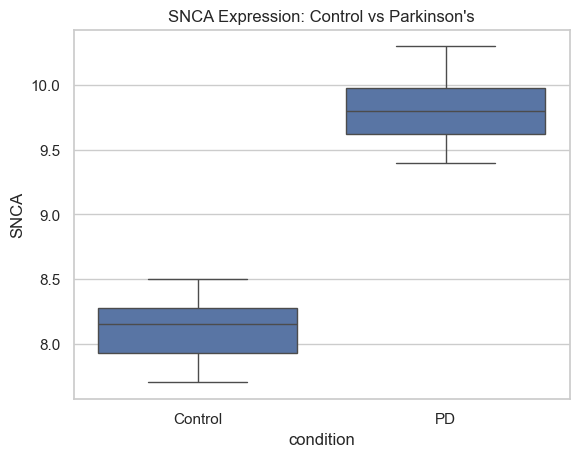

In [28]:
# Visualize the difference
sns.boxplot(data=data, x='condition', y='SNCA')
plt.title('SNCA Expression: Control vs Parkinson\'s')

### The P-value Concept

**P-value** = The probability of seeing a difference this large (or larger) **if there was in fact no real difference** between the groups.

- Assuming the "null hypothesis": there is NO difference between groups
- P-value tells us: how likely would we observe our data under this assumption?

**Interpretation:**
- Small p-value (< 0.05) → "The difference is unlikely to be just chance" → **Statistically significant**
- Large p-value (> 0.05) → "The difference could be explained by random chance" → **Not significant**

### Visually

Imagine two overlapping distributions. Even if they come from the **same** population, random sampling will give slightly different means.

Text(0.5, 1.0, 'SNCA: Clear separation → likely significant')

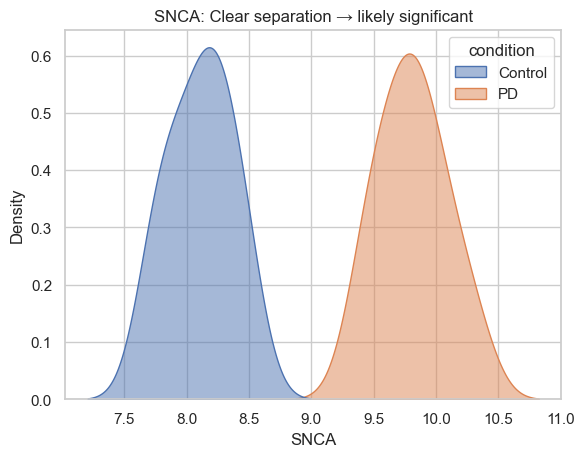

In [29]:
# SNCA expression - separated distributions
sns.kdeplot(data=data, x='SNCA', hue='condition', fill=True, alpha=0.5)
plt.title('SNCA: Clear separation → likely significant')

Text(0.5, 1.0, 'COMT: Large overlap → probably not significant')

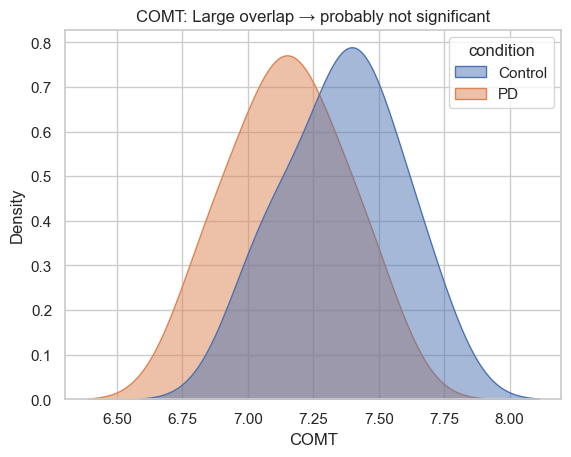

In [30]:
# COMT expression - overlapping distributions  
sns.kdeplot(data=data, x='COMT', hue='condition', fill=True, alpha=0.5)
plt.title('COMT: Large overlap → probably not significant')

---
## Part 3: The t-test

The **t-test** compares the means of two groups and gives us a p-value.

**Assumptions:**
- Data is approximately normally distributed
- Groups have similar variance
- Observations are independent

### Independent samples t-test

Use when comparing two **independent** groups (like Control vs PD).

In [31]:
# t-test for SNCA
control_snca = data[data['condition'] == 'Control']['SNCA']
pd_snca = data[data['condition'] == 'PD']['SNCA']

In [33]:
pd_snca

10     9.8
11    10.1
12     9.5
13     9.9
14    10.3
15     9.6
16     9.7
17    10.0
18     9.4
19     9.8
Name: SNCA, dtype: float64

In [ ]:
stats.ttest_ind?

In [35]:
t_stat, p_value = stats.ttest_ind(control_snca, pd_snca)

print("t-statistic:", round(t_stat, 3))
print("p-value:", p_value)

t-statistic: -14.156
p-value: 3.384277672485882e-11


**Interpretation:**
- p-value is small (< 0.05)
- The difference in SNCA expression between Control and PD is **statistically significant**
- SNCA is upregulated in Parkinson's disease

In [36]:
# t-test for COMT (less difference expected)
control_comt = data[data['condition'] == 'Control']['COMT']
pd_comt = data[data['condition'] == 'PD']['COMT']

t_stat, p_value = stats.ttest_ind(control_comt, pd_comt)

print("t-statistic:", round(t_stat, 3))
print("p-value:", round(p_value, 4))

t-statistic: 2.162
p-value: 0.0443


**Interpretation:**
- p-value is larger (closer to or above 0.05)
- The difference in COMT expression is **marginally statistically significant**

### Testing multiple genes

In [46]:
# Get list of gene columns (exclude sample_id and condition)
genes = data.columns[2:]

print("Genes:", list(genes))

Genes: ['SNCA', 'PARK2', 'PINK1', 'DJ1', 'LRRK2', 'GBA', 'ATP13A2', 'MAPT', 'BDNF', 'TH', 'SLC6A3', 'DRD2', 'COMT', 'GAD1', 'SYP']


In [47]:
# Run t-test for each gene
results = []

for gene in genes:
    control = data[data['condition'] == 'Control'][gene]
    pd_group = data[data['condition'] == 'PD'][gene]
    
    t_stat, p_val = stats.ttest_ind(control, pd_group)
    
    results.append({
        'gene': gene,
        'control_mean': round(control.mean(), 2),
        'pd_mean': round(pd_group.mean(), 2),
        'difference': round(pd_group.mean() - control.mean(), 2),
        'p_value': p_val
    })

# Create results table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('p_value')
results_df

,gene,control_mean,pd_mean,difference,p_value
9,TH,9.00,7.15,-1.85,1.119265e-12
10,SLC6A3,7.27,5.75,-1.52,3.080806e-11
0,SNCA,8.11,9.81,1.70,3.384278e-11
1,PARK2,7.53,6.15,-1.38,6.401523e-10
5,GBA,8.21,7.05,-1.16,2.611916e-09
14,SYP,7.94,6.95,-0.99,6.649309e-09
8,BDNF,6.57,5.55,-1.02,1.796225e-08
4,LRRK2,5.94,6.85,0.91,2.410340e-08
6,ATP13A2,6.24,5.35,-0.89,3.366445e-08
3,DJ1,7.13,6.25,-0.88,4.620294e-08


In [ ]:
# Which genes are significantly different? (p < 0.05)
significant = results_df[results_df['p_value'] < 0.05]
print("Significantly different genes:")
significant

---
## Part 4: Mann-Whitney U Test

The **Mann-Whitney U test** (also called Wilcoxon rank-sum test) is a **non-parametric** alternative to the t-test.

**When to use:**
- Data is not normally distributed
- Small sample sizes
- Ordinal data (rankings)
- Outliers present

**How it works:**
- Ranks all values from both groups together
- Compares the sum of ranks between groups
- Does NOT assume normal distribution

In [48]:
# Mann-Whitney U test for SNCA
control_snca = data[data['condition'] == 'Control']['SNCA']
pd_snca = data[data['condition'] == 'PD']['SNCA']

u_stat, p_value = stats.mannwhitneyu(control_snca, pd_snca)

print("U-statistic:", u_stat)
print("p-value:", p_value)

U-statistic: 0.0
p-value: 0.00018063472080753515


### Comparing t-test vs Mann-Whitney

In [49]:
# Compare both tests for all genes
comparison = []

for gene in genes:
    control = data[data['condition'] == 'Control'][gene]
    pd_group = data[data['condition'] == 'PD'][gene]
    
    _, p_ttest = stats.ttest_ind(control, pd_group)
    _, p_mannwhitney = stats.mannwhitneyu(control, pd_group)
    
    comparison.append({
        'gene': gene,
        'p_ttest': round(p_ttest, 4),
        'p_mannwhitney': round(p_mannwhitney, 4)
    })

comparison_df = pd.DataFrame(comparison)
comparison_df

,gene,p_ttest,p_mannwhitney
0,SNCA,0.0000,0.0002
1,PARK2,0.0000,0.0002
2,PINK1,0.0000,0.0002
3,DJ1,0.0000,0.0002
4,LRRK2,0.0000,0.0002
5,GBA,0.0000,0.0002
6,ATP13A2,0.0000,0.0002
7,MAPT,0.0000,0.0002
8,BDNF,0.0000,0.0002
9,TH,0.0000,0.0002


- For most genes, both tests give similar results
- Small differences are normal
- If results differ dramatically, investigate your data distribution

### When to use which test?

| Situation | Use |
|-----------|-----|
| Normal data, large samples (n > 30) | t-test |
| Non-normal data | Mann-Whitney |
| Small samples (n < 30) | Mann-Whitney (safer) |
| Ordinal data (rankings) | Mann-Whitney |
| Unsure about distribution | Mann-Whitney |

---
## Part 5: Visualizing Results

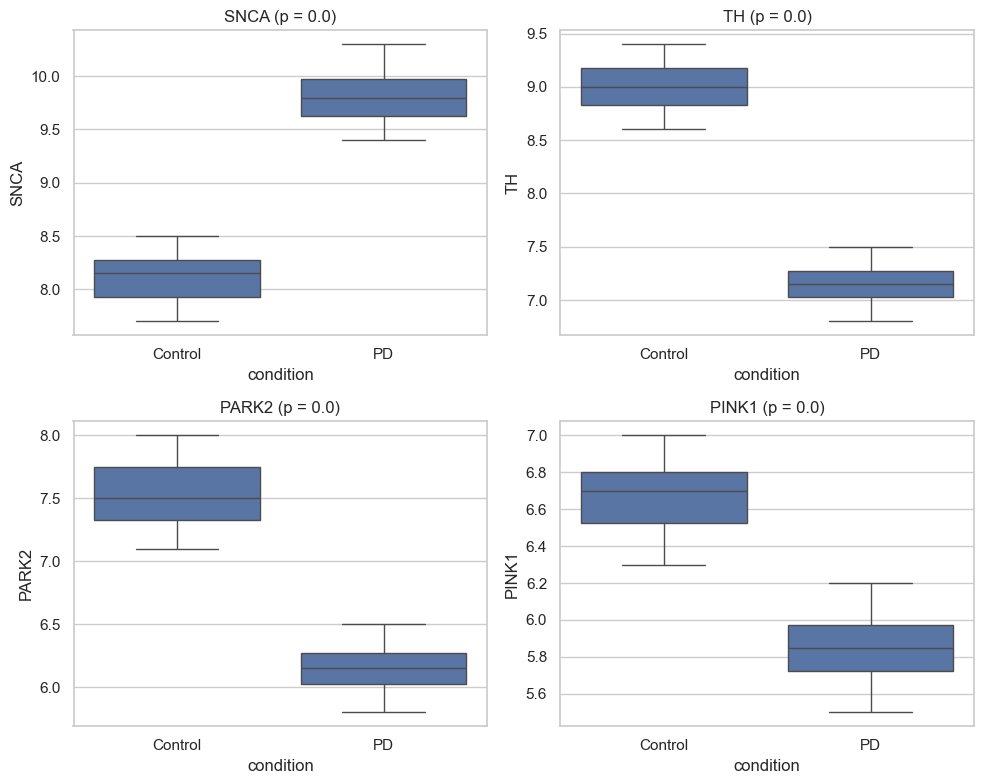

In [50]:
# Box plots for top significant genes
top_genes = ['SNCA', 'TH', 'PARK2', 'PINK1']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, gene in enumerate(top_genes):
    sns.boxplot(data=data, x='condition', y=gene, ax=axes[i])
    
    # Get p-value
    ctrl = data[data['condition'] == 'Control'][gene]
    pd_g = data[data['condition'] == 'PD'][gene]
    _, p = stats.ttest_ind(ctrl, pd_g)
    
    axes[i].set_title(gene + ' (p = ' + str(round(p, 4)) + ')')

plt.tight_layout()
plt.show()

---
## Part 6: Summary

**Loading data:**
- `pd.read_csv(url)` or `pd.read_csv("file.csv")`

**P-value:**
- Probability of seeing the observed difference if there was no real effect
- p < 0.05 → statistically significant
- p > 0.05 → not significant

**t-test:**
- `stats.ttest_ind(group1, group2)` for independent samples
- Assumes normal distribution
- Returns (t-statistic, p-value)

**Mann-Whitney U test:**
- `stats.mannwhitneyu(group1, group2)`
- Non-parametric (no normality assumption)
- Safer for small samples or non-normal data

---
## Exercises

### Exercise 1
Perform a t-test on the BDNF gene. Is the difference significant?

In [ ]:
# YOUR CODE HERE


### Exercise 2
Create a box plot for the TH gene (Tyrosine hydroxylase). Add the p-value to the title.

In [ ]:
# YOUR CODE HERE


### Exercise 3
Compare the t-test and Mann-Whitney U test results for the LRRK2 gene. Do they agree?

In [ ]:
# YOUR CODE HERE


---
## Resources

- [SciPy t-test documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
- [SciPy Mann-Whitney documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)
- [Understanding p-values](https://www.nature.com/articles/nmeth.4210)
- [GEO Database](https://www.ncbi.nlm.nih.gov/geo/) - source of original data

---

**Next class (28/1/26):** Hands-on project, case study

---
*NEURO-105 - MSc in Neurosciences, University of Crete*